# CONTENTS

I. Import necessary packages, aka, "Why write all over again, code that someone else has written ?"

II. Understanding the problem, load the data (how else can we get started ?) and some preprocessing

III. Approach I Fine tuninng your CNN

IV. Approach II : Using your CNN as a feature extractor

V. Ready to train the model, and look at its performance ?

# Import necessary packages, aka, "Why write all over again, code that someone else has written ?"

In [2]:
from __future__ import print_function, division

# All the torch stuff goes here...

import torch
import torch.nn as nn # Look at that, no need to say anything specific like Conv2D or Maxpool2D here !!!
import torch.optim as optim
from torch.optim import lr_scheduler

# All the torch vision stuff goes next...

import torchvision
from torchvision import datasets, models, transforms

#All the non-torchy stuff goes last...

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode !

# Understanding the problem, load the data (how else can we get started ?) and some preprocessing

In [3]:
%pwd

'/Users/ram/Desktop/INFO 7390'

In [4]:
'''Image classification using a small dataset. This one happens to be a binary classification problem.
Specifically we want to tell apart ants from bees.


The training set size is 120 and the validation set size is 75.

We do data augmentation for the training set. Why ? Well because people take pictures in different ways !
Fortunately, given one picture, we can recreate some of the other ways the same picture could have been taken.
Say, from another angle !

For both training and validation data, we also crop and normalize. Why ?
Looks like no one likes large numbers, especially when things are different across pictures !
Define these functions beforehand'''

data_dir = '/Users/ram/Desktop/INFO 7390/hymenoptera_data' #Don't forget the data !

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Note those funny decimal numbers you see there are actually the means and standard deviations 
#for the three channels. Those were pre-computed for this example. You can use a package like 
#Python openCV to compute these


In [5]:
'''Time to read-in the data'''

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [6]:
'''Get some basic information about the datasets which we will need later !'''

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} 

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Nope all my laptop has is a humble CPU

In [7]:
'''Print those out !'''
print(dataset_sizes,class_names)

{'train': 244, 'val': 153} ['ants', 'bees']


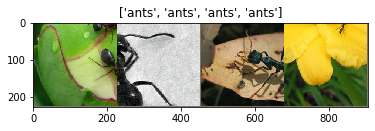

In [8]:
'''Never trust numbers by themselves, especially, when you can see the pictures !'''

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Approach I Fine tuninng your CNN

In [9]:
'''Define functions for training the model and visualizing the results. After every
epoch of training, the model is evaluated on the validation set.'''

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) #How else can you capture the weights of best model !
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # trash the parameter gradients after every minibatch !!! Till here

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train': # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)  # calculate statistics
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [10]:
'''Time to Finetune resnet'''

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
'''Train and evaluate the model'''

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5704 Acc: 0.7090
val Loss: 0.1919 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4074 Acc: 0.7992
val Loss: 0.2444 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5092 Acc: 0.7705
val Loss: 0.2976 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.5409 Acc: 0.7787
val Loss: 0.2961 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.6355 Acc: 0.7582
val Loss: 0.3590 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.5358 Acc: 0.8074
val Loss: 0.2888 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.6086 Acc: 0.7951
val Loss: 0.4764 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.6924 Acc: 0.8197
val Loss: 0.3336 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3519 Acc: 0.8770
val Loss: 0.2863 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.4297 Acc: 0.8607
val Loss: 0.2922 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.2980 Acc: 0.8975
val Loss: 0.2852 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2415 Acc: 0.8811
val Loss: 0.2513 Acc: 0.9150

Ep

# Approach II : Using your CNN as a feature extractor

In [14]:
'''"Freeze" all layers except the final layer'''

model_cnn = torchvision.models.resnet18(pretrained=True)

for param in model_cnn.parameters():
    param.requires_grad = False        

# Parameters of newly constructed modules have requires_grad=True by default

num_ftrs = model_cnn.fc.in_features
model_cnn.fc = nn.Linear(num_ftrs, 2)

model_cnn = model_cnn.to(device)

criterion = nn.CrossEntropyLoss()

# But, final layer needs to be optimized and decay the LR, by say, 0.7 every 7 epochs

optimizer_cnn = optim.SGD(model_cnn.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

# Ready to train the model, and look at its performance ?

In [15]:
'''Non GPU folks like me, please be patient...'''

model_cnn = train_model(model_cnn, criterion, optimizer_cnn,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5387 Acc: 0.7459
val Loss: 0.2318 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4784 Acc: 0.7910
val Loss: 0.2055 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.5007 Acc: 0.8074
val Loss: 0.2515 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5989 Acc: 0.7623
val Loss: 0.3051 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.4769 Acc: 0.8115
val Loss: 0.2238 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4468 Acc: 0.7992
val Loss: 0.4333 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.5698 Acc: 0.7787
val Loss: 0.3111 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3692 Acc: 0.8443
val Loss: 0.1837 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3563 Acc: 0.8320
val Loss: 0.1815 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3505 Acc: 0.8238
val Loss: 0.2093 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4166 Acc: 0.8197
val Loss: 0.2061 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4168 Acc: 0.8238
val Loss: 0.2051 Acc: 0.9477

Ep